Iniciando la carga del archivo 'base_final_s.csv'... Por favor, espera.
Carga completada exitosamente en 34.27 segundos.
Dimensiones del DataFrame: (5340181, 24)
Datos cargados
Datos de DIVIPOLA cargados
Columnas ajustadas:
Index(['Codigo_Departamento', 'Nombre_Departamento', 'Codigo_Municipio',
       'Nombre_Municipio', 'Tipo:_Municipio_/_Isla_/_Area_no_municipalizada',
       'longitud', 'Latitud'],
      dtype='object')
Procesando datos en fragmentos...
Procesamiento completado.


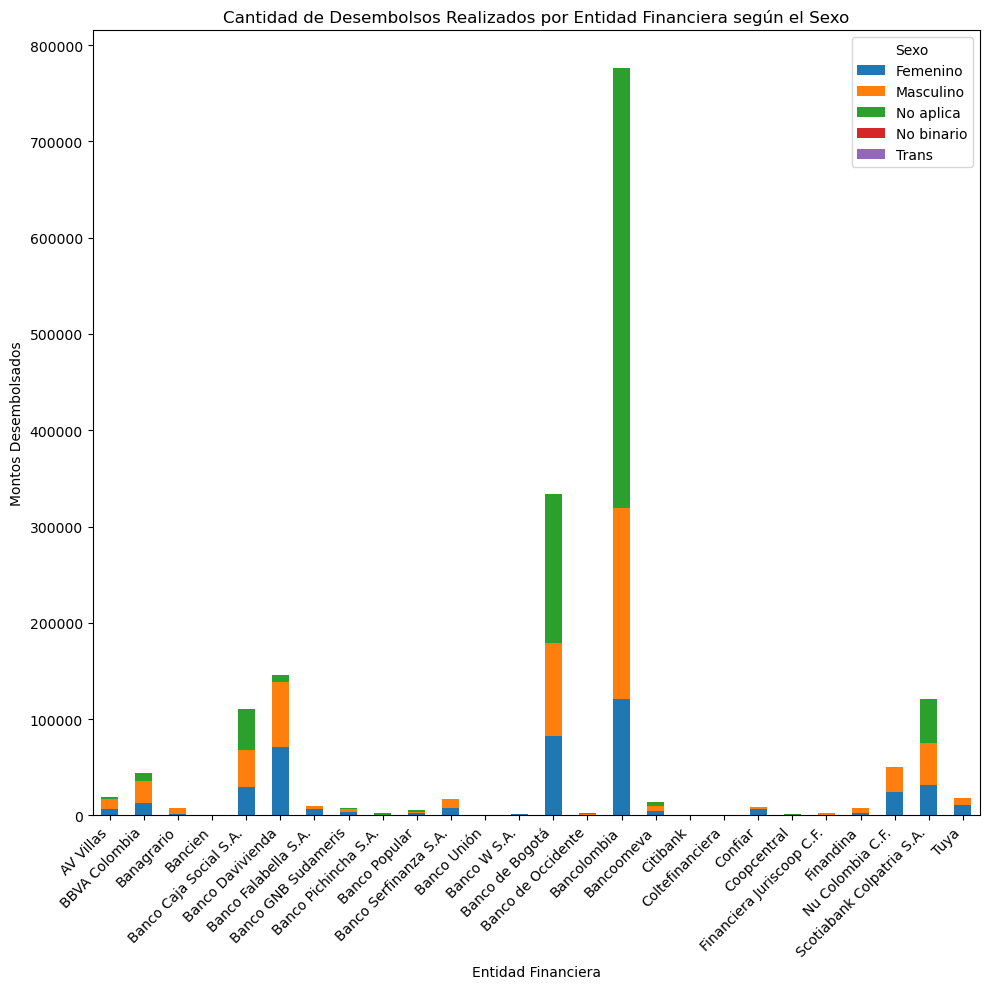

Sexo                        Femenino  Masculino  No aplica  No binario  Trans
Nombre_Entidad                                                               
AV Villas                    6939.18    9524.53    2689.88         0.0    0.0
BBVA Colombia               13086.61   22394.11    8957.07         0.0    0.0
Banagrario                   1683.38    6393.23       2.21         0.0    0.0
Bancien                         0.00     100.00       0.00         0.0    0.0
Banco Caja Social S.A.      29501.64   38212.72   42875.25         0.0    0.0
Banco Davivienda            70697.59   67561.52    7889.02         0.0    0.0
Banco Falabella S.A.         6966.72    3141.35       0.00         0.0    0.0
Banco GNB Sudameris          3631.59    3270.52     731.71         0.0    0.0
Banco Pichincha S.A.          277.47      24.17    1862.38         0.0    0.0
Banco Popular                2257.00     649.00    2813.38         0.0    0.0
Banco Serfinanza S.A.        7277.00    9775.00       0.00         0.0    0.0
Banco Unión                   550.00      50.00       0.00         0.0    0.0
Banco W S.A.                  990.00       0.00       0.00         0.0    0.0
Banco de Bogotá             82060.00   96957.00  154720.00         0.0    0.0
Banco de Occidente            458.36    1026.92    1139.37         0.0    0.0
Bancolombia                120355.57  199263.07  457005.45         0.0    0.0
Bancoomeva                   4783.46    4639.03    4454.25         0.0    0.0
Citibank                        0.00       0.00     354.36         0.0    0.0
Coltefinanciera               100.00       0.00     100.00         0.0    0.0
Confiar                      6765.00    1746.00       0.00         0.0    0.0
Coopcentral                   632.00       0.00     200.00         0.0    0.0
Financiera Juriscoop C.F.     200.00    1815.00       0.00         0.0    0.0
Finandina                    2598.00    4762.00       0.00         0.0    0.0
Nu Colombia C.F.            23983.89   26591.62       0.00         0.0    0.0
Scotiabank Colpatria S.A.   31423.83   43443.82   45471.40         0.0    0.0
Tuya                        10687.80    7304.21       0.00         0.0    0.0

In [29]:
import data_loader
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool


# Cargar base_final_s.csv
base = data_loader.cargar_base_datos()
if base is not None:
    print("Datos cargados")
else:
    print("Falló la carga de base_final_s.csv")

# Cargar DIVIPOLA
df_divipola = data_loader.cargar_divipola()
if df_divipola is not None:
    print("Datos de DIVIPOLA cargados")




df_municipios = df_divipola.copy()
df_base = base.copy()


import unicodedata
def quitar_tildes(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

# Quitar tildes de los nombres de las columnas
df_municipios.columns = [quitar_tildes(col) for col in df_municipios.columns]


# Definir la función
def limpiar_nombres_columnas(df):
    nuevos_nombres = {col: col.replace(' ', '_') for col in df.columns}
    df_municipios.rename(columns={'Tipo:_Municipio_/_Isla_/_Area_no_municipalizada': 'Tipo_municipio'}, inplace=True)
    df_municipios.rename(columns={'Codigo_Municipio': 'Codigo_Municipio'}, inplace=True)
    df = df.rename(columns=nuevos_nombres)
    return df

# Aplicar la función a df_municipios
df_municipios = limpiar_nombres_columnas(df_municipios)

# Verificar los nuevos nombres de columnas
print("Columnas ajustadas:")
print(df_municipios.columns)


#Definimos nuevamente las columnas con las que vamos a trabajar
columnas = ['Tipo_Entidad', 'Nombre_Tipo_Entidad', 'Codigo_Entidad',
       'Nombre_Entidad', 'Fecha_Corte', 'Tipo_de_persona', 'Sexo',
       'Tamaño_de_empresa', 'Tipo_de_crédito', 'Tipo_de_garantía',
       'Producto de crédito', 'Plazo de crédito',
       'Tasa_efectiva_promedio_ponderada', 'margen_adicional',
       'Montos_desembolsados', 'Numero_de_creditos_desembolsados',
       'Grupo_Etnico', 'Antiguedad_de_la_empresa', 'Tipo_de_Tasa',
       'Rango_monto_desembolsado', 'Clase_deudor', 'Codigo_CIIU',
       'Codigo_Municipio']
df_base = df_base.reindex(columns = columnas)


import pandas as pd
import matplotlib.pyplot as plt

# Variable global
desembolsos_por_sexo = None

# Función para procesar cada fragmento
def procesar_fragmento(fragmento):
    fragmento['Montos_desembolsados'] = pd.to_numeric(fragmento['Montos_desembolsados'], errors='coerce')
    return fragmento.groupby(['Nombre_Entidad', 'Sexo'])['Montos_desembolsados'].sum()

# Función para procesar los datos
def cargar_y_procesar_datos(df):
    global desembolsos_por_sexo
    chunk_size = 5000000
    n_chunks = len(df) // chunk_size + 1
    resultados = []
    
    print("Procesando datos en fragmentos...")
    for i in range(n_chunks):
        chunk = df.iloc[i * chunk_size:(i + 1) * chunk_size]
        resultado = procesar_fragmento(chunk)
        resultados.append(resultado)
    
    if resultados:
        desembolsos_por_sexo = pd.concat(resultados).groupby(level=[0, 1]).sum().unstack()
        desembolsos_por_sexo.fillna(0, inplace=True)
        desembolsos_por_sexo = desembolsos_por_sexo.loc[(desembolsos_por_sexo > 0).any(axis=1)]
        print("Procesamiento completado.")
    else:
        print("No se procesaron datos. Verifica las columnas 'Nombre_Entidad', 'Sexo' y 'Montos_desembolsados'.")

# Función para graficar
def graficar_datos():
    if desembolsos_por_sexo is not None and not desembolsos_por_sexo.empty:
        desembolsos_por_sexo.plot(kind='bar', stacked=True, figsize=(10, 10))
        plt.title('Cantidad de Desembolsos Realizados por Entidad Financiera según el Sexo')
        plt.xlabel('Entidad Financiera')
        plt.ylabel('Montos Desembolsados')
        plt.legend(title='Sexo')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("No hay datos numéricos mayores a cero para graficar.")

# Ejecutar con Tabla_dep
cargar_y_procesar_datos(Tabla_dep)
graficar_datos()

#Mostramos una tabla resumen
desembolsos_por_sexo

Oportunidades de mejora
- Un try catch para validar la disponibilidad de la pagina para descarga - Revisar codigo de Melissa - Ok
- Validar y almacenar los notebook para guardar como funciones y guardarlo con extensión py para extraer la data.  - Ok
- Realizar el análisis descriptivo de la data - En proceso 
- Validar cual va a ser el procedimiento y definir el paso a paso   
**2.** Archivo de Excel que contenga las siguientes tablas:  
     **-** Cantidad de desembolsos realizados por cada entidad financiera por cada tipo de crédito. - M  
     **-** Cantidad de desembolsos realizados por entidad financiera de acuerdo al sexo.  - J
     **-** Top 7 de municipios con mayor número de desembolsos.  - M
     **-** Top 7 de municipios con menor número de desembolsos.  - M   
     **-** Cantidad de desembolsos realizados por la entidad en función del rango del desembolso.     - J
     **-** Top 10 de municipios con mayor número de desembolsos desagregados por Sexo. - J
  